In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777)
np.random.seed(777)
torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [11]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_transforms={'train':train_transform, 'val':val_transform}

In [12]:
data_dir = "data/dog_cat"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = train_dataset.classes

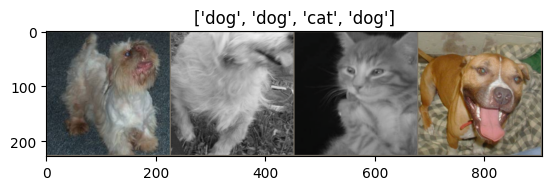

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) 
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train'])) 

# Make a grid from batch
out = torchvision.utils.make_grid(inputs) 
imshow(out, title=[class_names[x] for x in classes])

## classifier만 학습

In [20]:
def train_model(model, criterion, optimizer, model_name, scheduler, num_epochs=25):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            lr = scheduler.get_last_lr()[0]
            print('{} Loss: {:.4f} Acc: {:.4f} LR: {:.6f}'.format(
                phase, epoch_loss, epoch_acc, lr))

            # save model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                content = {
                    'epoch': epoch,
                    'acc': epoch_acc,
                    'model': model.state_dict()
                }
                torch.save(content, f'{model_name}.pt')

        # learning rate scheduler
        scheduler.step()

    print('Best val Acc: {:4f}'.format(best_acc))

In [21]:
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.subplot(num_images//2, 2, images_so_far)
                plt.axis('off')
                plt.title('real: {} | predicted: {}'.format(class_names[labels[j]],
                                                            class_names[preds[j]]))
                img = inputs.cpu().data[j].permute(1,2,0)*std+mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    return

In [23]:
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

num_in = resnet.fc.in_features
resnet.fc = nn.Linear(num_in,2)

resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters())
lr_schedule = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
num_epochs = 10

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
train_model(resnet,
            criterion, 
            optimizer,
            model_name='resnet2',
            scheduler=lr_schedule,
            num_epochs=num_epochs)

Epoch 1/10
----------
train Loss: 0.3643 Acc: 0.8416 LR: 0.000904
val Loss: 0.1042 Acc: 0.9608 LR: 0.000904
Epoch 2/10
----------
train Loss: 0.5961 Acc: 0.7129 LR: 0.000895
val Loss: 0.1470 Acc: 0.9314 LR: 0.000895
Epoch 3/10
----------
train Loss: 0.4288 Acc: 0.7921 LR: 0.000886
val Loss: 0.0973 Acc: 0.9608 LR: 0.000886
Epoch 4/10
----------
train Loss: 0.3790 Acc: 0.8267 LR: 0.000878
val Loss: 0.1093 Acc: 0.9608 LR: 0.000878
Epoch 5/10
----------
train Loss: 0.3983 Acc: 0.7970 LR: 0.000869
val Loss: 0.0779 Acc: 0.9804 LR: 0.000869
Epoch 6/10
----------
train Loss: 0.3069 Acc: 0.8564 LR: 0.000860
val Loss: 0.0917 Acc: 0.9706 LR: 0.000860
Epoch 7/10
----------
train Loss: 0.3257 Acc: 0.8812 LR: 0.000851
val Loss: 0.0809 Acc: 0.9804 LR: 0.000851
Epoch 8/10
----------
train Loss: 0.3837 Acc: 0.8515 LR: 0.000843
val Loss: 0.0781 Acc: 0.9902 LR: 0.000843
Epoch 9/10
----------
train Loss: 0.2817 Acc: 0.8614 LR: 0.000835
val Loss: 0.0818 Acc: 0.9804 LR: 0.000835
Epoch 10/10
----------
train

In [26]:
ckpt = torch.load('resnet2.pt')
resnet.load_state_dict(ckpt['model'])

<All keys matched successfully>

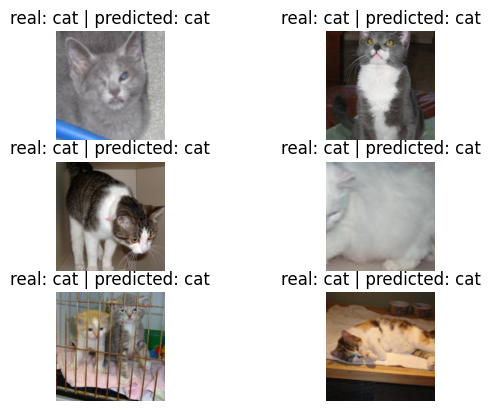

In [27]:
visualize_model(resnet)

## 전체 학습

In [30]:
resnet = models.resnet18(pretrained=True)
num_in = resnet.fc.in_features
resnet.fc = nn.Linear(num_in,2)

resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.fc.parameters(), 
                      lr=0.001, 
                      momentum=0.9)
num_epochs = 10

In [33]:
resnet = models.resnet18()
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)
resnet.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
lr_schedule = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

In [36]:
train_model(resnet,
            criterion, 
            optimizer,
            model_name='resnet_all2',
            scheduler=lr_schedule,
            num_epochs=num_epochs)

Epoch 1/10
----------
train Loss: 0.6703 Acc: 0.6139 LR: 0.000740
val Loss: 0.6231 Acc: 0.6667 LR: 0.000740
Epoch 2/10
----------
train Loss: 0.7608 Acc: 0.5842 LR: 0.000732
val Loss: 0.7006 Acc: 0.5588 LR: 0.000732
Epoch 3/10
----------
train Loss: 0.7149 Acc: 0.6337 LR: 0.000725
val Loss: 0.6217 Acc: 0.6667 LR: 0.000725
Epoch 4/10
----------
train Loss: 0.7443 Acc: 0.5743 LR: 0.000718
val Loss: 0.7517 Acc: 0.6078 LR: 0.000718
Epoch 5/10
----------
train Loss: 0.8071 Acc: 0.5347 LR: 0.000711
val Loss: 0.9977 Acc: 0.5098 LR: 0.000711
Epoch 6/10
----------
train Loss: 0.7886 Acc: 0.6040 LR: 0.000703
val Loss: 0.7022 Acc: 0.6569 LR: 0.000703
Epoch 7/10
----------
train Loss: 0.7038 Acc: 0.5842 LR: 0.000696
val Loss: 0.6787 Acc: 0.5882 LR: 0.000696
Epoch 8/10
----------
train Loss: 0.7022 Acc: 0.5891 LR: 0.000689
val Loss: 0.8834 Acc: 0.5294 LR: 0.000689
Epoch 9/10
----------
train Loss: 0.9193 Acc: 0.5990 LR: 0.000683
val Loss: 0.7217 Acc: 0.6667 LR: 0.000683
Epoch 10/10
----------
train

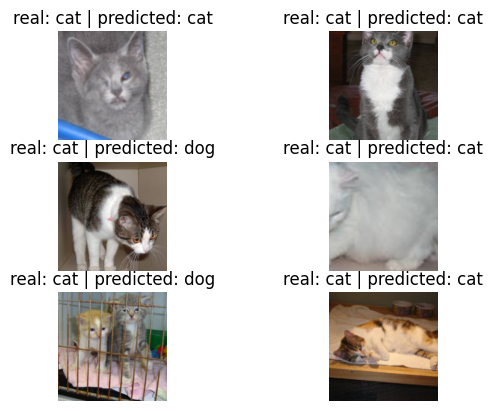

In [38]:
ckpt = torch.load('resnet_all2.pt')
resnet.load_state_dict(ckpt['model'])
visualize_model(resnet)